# Assignment 3: Image Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [13]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [14]:
# from google.colab import drive
# drive.mount('/content/gdrive')

After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair.
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [15]:
import pickle


# for Yhonatan:
path = '/Users/yhonatangayer/Library/CloudStorage/OneDrive-post.bgu.ac.il/BGU/Semster 7/Deep Learning/EX3/data/'
with open(path+'train_data_array.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(path + 'valid_data_array.pkl', 'rb') as f:
    valid_data = pickle.load(f)
with open(path + 'test_w_array.pkl', 'rb') as f:
    test_w = pickle.load(f)
with open(path + 'test_w_array.pkl', 'rb') as f:
    test_m = pickle.load(f)

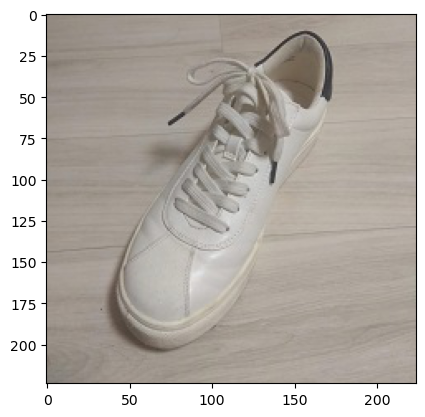

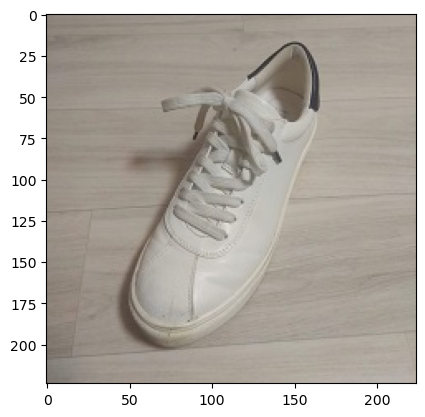

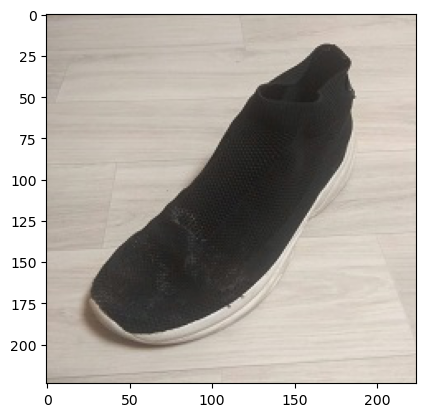

In [16]:
# Run this code, include the image in your PDF submission
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.add(train_data[4,0,0,:,:,:],0.5)) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(np.add(train_data[4,0,1,:,:,:],0.5)) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(np.add(train_data[4,1,1,:,:,:],0.5)) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


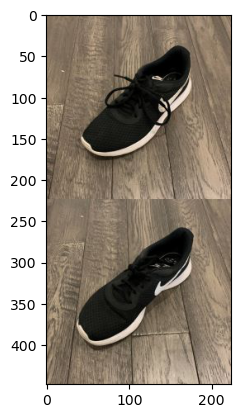

In [17]:
def generate_same_pair(data_set):
  res = np.empty((np.shape(data_set)[0] * np.shape(data_set)[1], 448,224,3))
  for i in range(np.shape(data_set)[0]):
    for j in range(np.shape(data_set)[1]):
      tmp_left = np.array(data_set[i,j,0,:,:,:])
      tmp_right = np.array(data_set[i,j,1,:,:,:])
      tmp_merged = np.concatenate((tmp_left, tmp_right), axis=0)
      res[(i+1)*(j+1)-1,:,:,:] = tmp_merged
  return res

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(np.add(train_data,0.5))[0]) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


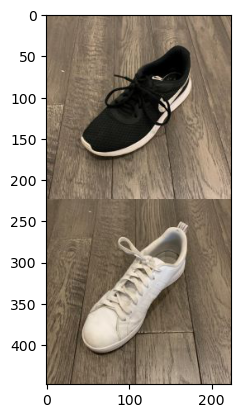

In [18]:
def generate_different_pair(data_set):
  res = np.empty((np.shape(data_set)[0] * np.shape(data_set)[1], 448,224,3))
  for i in range(np.shape(data_set)[0]):
    tmp_left0  = np.array(data_set[i,0,0,:,:,:])
    tmp_left1  = np.array(data_set[i,1,0,:,:,:])
    tmp_left2  = np.array(data_set[i,2,0,:,:,:])
    tmp_right0 = np.array(data_set[i,0,1,:,:,:])
    tmp_right1 = np.array(data_set[i,1,1,:,:,:])
    tmp_right2 = np.array(data_set[i,2,1,:,:,:])
    tmp_merged0 = np.concatenate((tmp_left0, tmp_right1), axis=0)
    tmp_merged1 = np.concatenate((tmp_left1, tmp_right2), axis=0)
    tmp_merged2 = np.concatenate((tmp_left2, tmp_right0), axis=0)
    res[(i+1)*(0+1)-1,:,:,:] = tmp_merged0
    res[(i+1)*(1+1)-1,:,:,:] = tmp_merged1
    res[(i+1)*(2+1)-1,:,:,:] = tmp_merged2

  return res
# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(np.add(generate_different_pair(train_data)[0],0.5)) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

If we use the different pairs from different persons we will get more differences in the images due to different scene
different background, lighting,distance from camera, etc.
also by using the same person we get the same shoe size even though the shoes aren't match.
When we are using different pairs from the same person we give the model more similar futures to relay on.
so in each image of different pairs, the model will have to learn the differences in the shoe details and won't be able to relay on other differences in the scene or in the shoe size.
that way we make the model accurate to do its purpose as we want.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

It is important that our data will be balanced, because when we train a NN model, the model also taking in consider the apriori-cal probability that each image will be from the same pair or from a different pair.
that means that if we will train the model on a data set where 99% of the images are of shoes that are not from the same pair, we will get a NN that influenced by an un i.i.d data set.
for our task we want the NN to be able to guess  an unbiased guess if the shoes are from the same pair or not, the best way to make sure that our guess won't be biased is by making sure that our train data is balanced, that means that it is i.i.d distributed.


## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [19]:
class CNN(nn.Module):
    def __init__(self, n=4, kernel_size = 3):
        super(CNN, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n,
                               kernel_size=kernel_size,
                               stride=2,
                               padding = (kernel_size-1)//2)
        self.conv2 = nn.Conv2d(in_channels=n,
                               out_channels=2 * n,
                               kernel_size=kernel_size,
                               stride=2,
                               padding = (kernel_size-1)//2)
        self.conv3 = nn.Conv2d(in_channels=2 * n,
                               out_channels=4 * n,
                               kernel_size=kernel_size,
                               stride=2,
                               padding = (kernel_size-1)//2)
        self.conv4 = nn.Conv2d(in_channels=4 * n,
                               out_channels=8 * n,
                               kernel_size=kernel_size,
                               stride=2,
                               padding = (kernel_size-1)//2)
        
        self.lin1 = nn.Linear(28*14*8*n, 100)
        self.lin2 = nn.Linear(100, 2)

    def forward(self, x, verbose=False):
        
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = F.relu(x)

        x = x.reshape(-1,28*14*8*self.n)                  #, self.n_feature*8)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)          # size of x is [392,2] , IT SHOULD BE [1,2]!! I THINK
        return x#torch.log_softmax(x, dim=1)

class CNN2(nn.Module):
    def __init__(self, n=4):
        super(CNN2, self).__init__()
        self.n=n
        self.MaxPool=nn.MaxPool2d(2, 2)
        # (3,448,224)
        self.conv3_2_n = nn.Conv2d(3, n, 3, padding = 1) # 3 to n, we chose kernel = 3, padding = (3-1)/2
        # (n,224,112)
        self.convn_2_2n = nn.Conv2d(n, 2*n,kernel_size = 3, padding = 1) # n to 2n, we chose kernel = 3, padding = (3-1)/2
        # (2n,112,56)
        self.conv2n_2_4n = nn.Conv2d(2*n, 4*n, kernel_size = 3, padding = 1) # 2n to 4n, we chose kernel = 3, padding = (3-1)/2
        # (4n,56,28)
        self.conv4n_2_8n = nn.Conv2d(4*n, 8*n,kernel_size = 3, padding = 1) # 4n to 8n, we chose kernel = 3, padding = (3-1)/2
        # (8n,28,14)
        self.fc1 = nn.Linear((8*n)*28*14,100)
        # 100
        self.fc2 = nn.Linear(100,2)
        # 2
    def forward(self, image):
        image = self.MaxPool(torch.relu(self.conv3_2_n(image)))
        image = self.MaxPool(torch.relu(self.convn_2_2n(image)))
        image = self.MaxPool(torch.relu(self.conv2n_2_4n(image)))
        image = self.MaxPool(torch.relu(self.conv4n_2_8n(image)))
        image = image.reshape(-1, 8 * self.n * 28 *14)                                #-1, 8 * self.n * 28 *14)
        image = torch.relu(self.fc1(image))
        image = self.fc2(image)
        return torch.log_softmax(image, dim = 1)

        # image = self.MaxPool(torch.relu(self.conv4n_2_8n(self.MaxPool(torch.relu(self.conv2n_2_4n(self.MaxPool(torch.relu(self.convn_2_2n(self.MaxPool(torch.relu(self.conv3_2_n(image))))))))))))
        # image = image.view(8 * self.n * 28 * 14)
        # image = torch.relu(self.fc1(image))

z = generate_same_pair(train_data) #(300, 448, 224, 3)
z2 = z[:32] #(32, 448, 224, 3)
z3 = torch.Tensor(z2).transpose(1, 3)#([32, 3, 224, 448]) - print(z3.size())
zs_out = CNN()(z3)
print(zs_out.size())
# img = torch.randn(3,448,224)
# net = CNN()
# pred = net(img)
# pred.shape

torch.Size([32, 2])


### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [20]:
class CNNChannel(nn.Module):
    def __init__(self, n=4, kernel_size = 3):
        super(CNNChannel, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=6,
                               out_channels=self.n,
                               kernel_size=kernel_size,
                               stride=2,
                               padding = (kernel_size-1)//2)
        self.conv2 = nn.Conv2d(in_channels=self.n,
                               out_channels=2 * self.n,
                               kernel_size=kernel_size,
                               stride=2,
                               padding = (kernel_size-1)//2)
        self.conv3 = nn.Conv2d(in_channels=2 * self.n,
                               out_channels=4 * self.n,
                               kernel_size=kernel_size,
                               stride=2,
                               padding = (kernel_size-1)//2)
        self.conv4 = nn.Conv2d(in_channels=4 * self.n,
                               out_channels=8 * self.n,
                               kernel_size=kernel_size,
                               stride=2,
                               padding = (kernel_size-1)//2)
        
        self.lin1 = nn.Linear(14*14*8*self.n, 100)
        self.lin2 = nn.Linear(100, 2)
    
    def forward(self, x, verbose=False):
        x = torch.cat((x[:,:,:,:224], x[:,:,:,224:]),1)
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = F.relu(x)

        x = x.reshape(-1,14*14*8*self.n)                  #, self.n_feature*8)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)          # size of x is [392,2] , IT SHOULD BE [1,2]!! I THINK
        return x#torch.log_softmax(x, dim=1)


## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**

In the first case, two images of shoes are count as one, for that reason the CNN will apply filters on the two images as if they were one image.it can cause some of the outcomes of the filters will have no reasonable meaning.
In class, we leaned that part of the reason that CNN works well on images is due to the locality and stationary, in the first case those qualities are not preserved and for that reason we can assume that CNN won't make good performance on them.

The second case we will apply filters on each image separately, so we will avoid of the nonsense outcomes we had in the first CNN we built.
we also make sure by separating the images that the stationary and locality of the images will preserve.

we expect better outcomes using the 2'nd CNN we built for the reasons we explained.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**

in this case, its important to track the the false positive and false negative separately, because we want to see and avoid a NN that might lean toward a certain conclusion for every pair of shows.

for instance, if a NN will estimate every 2 shows as the same pair, we all agree that the NN is not doing its job, and it learns NOTHING, and the acc on balanced data will be about 50%.
But if we will take a test_data that contains 80% of shows that come from the same pair - we will get 80% acc! a great result for a NN that don't know anything (a model that all it's predictions atre the same).

But if we will check the false positive we will see that its value is 100%
and we will understand immediately that the NN is worthless!
(we will need the false negative also for the exact opposite reasons.)

In [26]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 0).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 1).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [34]:
def train_model2(model,
                training_data = train_data,
                validation_data = valid_data,
                batch_size = 10, learning_rate = 0.001,
                weight_decay = 0,
                max_iters = 1000,
                checkpoint_path = None):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)


  same_pairs = generate_same_pair(train_data)
  different_pairs = generate_different_pair(train_data)
  iters, losses = [], []
  iters_sub, train_accs, val_accs  = [], [] ,[]
  n = 0 # iterations
  while True:
    np.random.shuffle(same_pairs)
    np.random.shuffle(different_pairs)
    for i in range(0, same_pairs.shape[0], batch_size):
      if (i + batch_size) > same_pairs.shape[0]:
        break

      same_pairs_batch = same_pairs[i:i + (batch_size // 2)]
      same_pairs_batch = torch.from_numpy(same_pairs_batch.transpose((0,3,2,1)))

      different_pairs_batch = different_pairs[i:i + (batch_size // 2)]
      different_pairs_batch = torch.from_numpy(different_pairs_batch.transpose((0,3,2,1)))

      xt = torch.cat((same_pairs_batch,different_pairs_batch))
      # print("the size of xt: " + str (xt.shape))
      same_labels = np.concatenate((np.ones([batch_size // 2,1]),np.zeros([batch_size // 2 , 1])),axis=1)
      different_labels = np.concatenate((np.zeros([batch_size // 2,1]),np.ones([batch_size // 2,1])),axis = 1)
      # print("the size of DL: " + str (different_labels.shape))
      all_labels = np.concatenate((same_labels,different_labels))
      # print("the size of AL: " + str (all_labels.shape))
      st = torch.Tensor(all_labels).float()
      # print("the size of st: " + str (st.shape))


      indices = torch.randperm(st.shape[0])
      # print(indices)
      st = st[indices,:]
      xt = xt[indices,:,:,:]
      # print("the size of xt: " + str (xt.shape))
      zs = model(xt.float())
      # print("the size of zs: " + str (zs.shape))
      loss = criterion(zs, st)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      iters.append(n)
      losses.append(float(loss)/batch_size)

      if n % 10 == 0:
        iters_sub.append(n)
        train_cost = float(loss.detach().numpy())

        train_pos_acc, train_neg_acc = get_accuracy(model, train_data, batch_size)
        train_accs.append((train_pos_acc + train_neg_acc) / 2.0)

        val_pos_acc, val_neg_acc = get_accuracy(model, validation_data, batch_size)
        val_accs.append((val_pos_acc + val_neg_acc) / 2.0)
        print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f][Val Neg Acc %.0f%%, train neg Acc %.0f%%][Val pos Acc %.0f%%, Train pos Acc %.0f%%]" % (
              n, ((val_pos_acc + val_neg_acc) / 2.0) * 100,
              ((train_pos_acc + train_neg_acc) / 2.0) * 100,
              train_cost ,
              val_neg_acc * 100,
              train_neg_acc * 100,
              val_pos_acc * 100,
              train_pos_acc * 100))

        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
      n = n + 1

      if n > max_iters:
          return iters, losses, iters_sub, train_accs, val_accs


def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

----------------------- CNN----------------------------
Iter 0. [Val Acc 50%] [Train Acc 50%, Loss 0.693956] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 100%, Pos Acc 0%]
Iter 10. [Val Acc 50%] [Train Acc 50%, Loss 0.695934] Val->[Neg Acc 0%, Pos Acc 100%] Train->[Neg Acc 0%, Pos Acc 100%]
Iter 20. [Val Acc 50%] [Train Acc 50%, Loss 0.693600] Val->[Neg Acc 0%, Pos Acc 100%] Train->[Neg Acc 0%, Pos Acc 100%]
Iter 30. [Val Acc 50%] [Train Acc 50%, Loss 0.693065] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 100%, Pos Acc 0%]
Iter 40. [Val Acc 50%] [Train Acc 50%, Loss 0.692873] Val->[Neg Acc 0%, Pos Acc 100%] Train->[Neg Acc 0%, Pos Acc 100%]
Iter 50. [Val Acc 50%] [Train Acc 50%, Loss 0.693297] Val->[Neg Acc 0%, Pos Acc 100%] Train->[Neg Acc 0%, Pos Acc 100%]
Iter 60. [Val Acc 50%] [Train Acc 51%, Loss 0.693106] Val->[Neg Acc 67%, Pos Acc 33%] Train->[Neg Acc 88%, Pos Acc 13%]
Iter 70. [Val Acc 50%] [Train Acc 50%, Loss 0.693498] Val->[Neg Acc 0%, Pos Acc 100%] Train->[Neg Acc 0%,

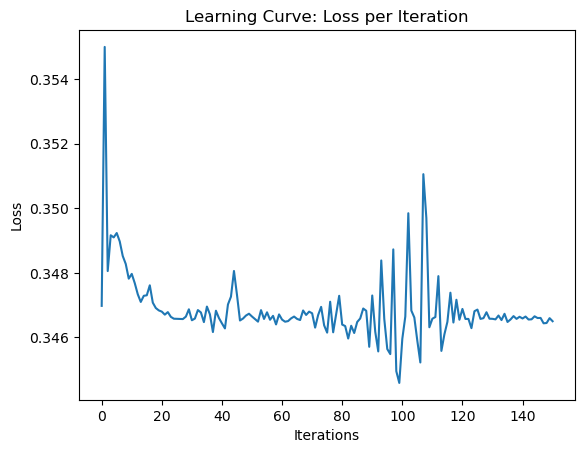

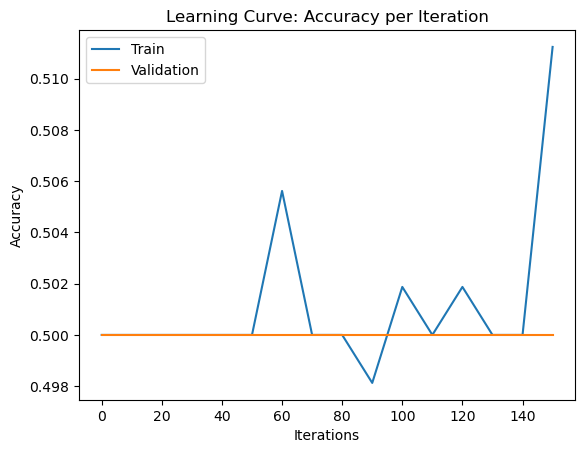

----------------------- CNNchannel----------------------
Iter 0. [Val Acc 50%] [Train Acc 50%, Loss 0.693187] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 100%, Pos Acc 0%]
Iter 10. [Val Acc 67%] [Train Acc 55%, Loss 0.676067] Val->[Neg Acc 33%, Pos Acc 100%] Train->[Neg Acc 21%, Pos Acc 90%]
Iter 20. [Val Acc 50%] [Train Acc 49%, Loss 0.703829] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 61%, Pos Acc 37%]
Iter 30. [Val Acc 67%] [Train Acc 58%, Loss 0.693342] Val->[Neg Acc 33%, Pos Acc 100%] Train->[Neg Acc 43%, Pos Acc 73%]
Iter 40. [Val Acc 50%] [Train Acc 50%, Loss 0.693339] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 100%, Pos Acc 0%]
Iter 50. [Val Acc 67%] [Train Acc 61%, Loss 0.629689] Val->[Neg Acc 33%, Pos Acc 100%] Train->[Neg Acc 25%, Pos Acc 98%]
Iter 60. [Val Acc 83%] [Train Acc 63%, Loss 0.360020] Val->[Neg Acc 67%, Pos Acc 100%] Train->[Neg Acc 28%, Pos Acc 99%]
Iter 70. [Val Acc 100%] [Train Acc 67%, Loss 0.505033] Val->[Neg Acc 100%, Pos Acc 100%] Train->[Neg

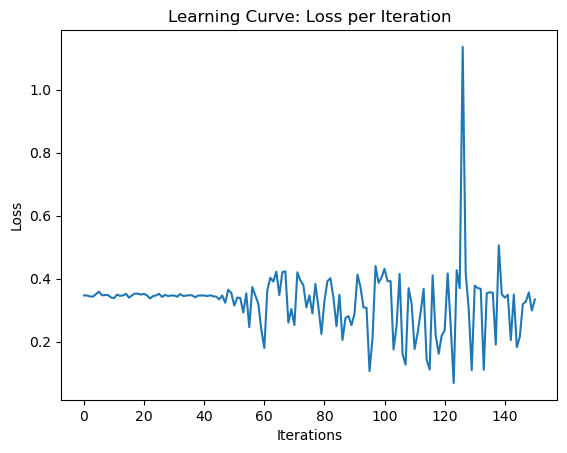

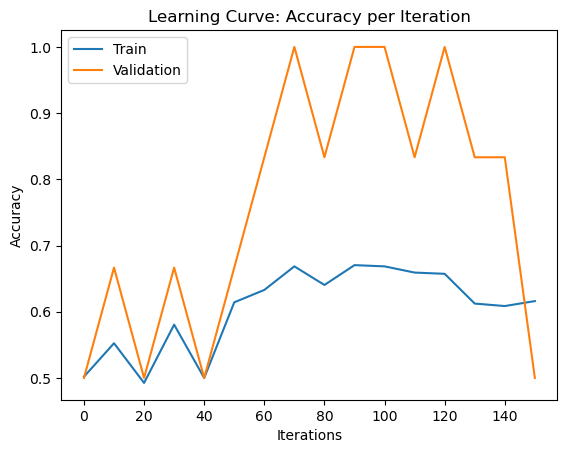

In [37]:
# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy.
print("----------------------- CNN----------------------------")

modelCNN = CNN()
dataCNN = train_model2(modelCNN,
                training_data = train_data[:1],
                validation_data = valid_data[:1],
                batch_size = 2,
                learning_rate = 0.001,
                weight_decay = 0,
                max_iters = 100,
                checkpoint_path = None)

print("CNN learning curves:")
plot_learning_curve(*dataCNN)

print("----------------------- CNNchannel----------------------")
modelCNNchannel = CNNChannel()
dataCNNchannel = train_model2(modelCNNchannel,
                training_data = train_data[:1],
                validation_data = valid_data[:1],
                batch_size = 2,
                learning_rate = 0.001,
                weight_decay = 0,
                max_iters = 100,
                checkpoint_path = None)

print("CNN channel learning curves:")
plot_learning_curve(*dataCNNchannel)



### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**

we started, as segguested, with a loop on the learning rate:

* best results for CNN were $μ = 0.001 (n=4, kernel=3, batch size = 32)$ 
* best results for CNNChannel were $μ = 0.001 (n=4, kernel=3, batch size = 32)$

(we got the same results for both of them.) 

after that, we search for the best n, kernel and batch size of each one of the model, the guidline was that for CNN we will allow 1200 iteration and only 500 for the CNNChannel model. also, we choose higher value for n and kernel size for the CNN model.

* best results for CNN were $$n=8, kernel=7, batch size = 32$$
* best results for CNNChannel were $$n = 6, kernel size = 5, batch size = 64$$ 


In [38]:
bestCNNchannel = CNN()
data_bestCNNchannel = train_model2(bestCNNchannel,
                                   train_data=train_data,
                                   max_iters=1200,
                                   batch_size=32,
                                   learning_rate=0.001)

Iter 0. [Val Acc 50%] [Train Acc 50%, Loss 0.694529] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 100%, Pos Acc 0%]
Iter 10. [Val Acc 50%] [Train Acc 50%, Loss 0.692791] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 100%, Pos Acc 0%]
Iter 20. [Val Acc 50%] [Train Acc 50%, Loss 0.693640] Val->[Neg Acc 0%, Pos Acc 100%] Train->[Neg Acc 0%, Pos Acc 100%]
Iter 30. [Val Acc 50%] [Train Acc 50%, Loss 0.693872] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 100%, Pos Acc 1%]
Iter 40. [Val Acc 55%] [Train Acc 50%, Loss 0.693385] Val->[Neg Acc 35%, Pos Acc 75%] Train->[Neg Acc 25%, Pos Acc 75%]
Iter 50. [Val Acc 60%] [Train Acc 50%, Loss 0.692415] Val->[Neg Acc 74%, Pos Acc 46%] Train->[Neg Acc 51%, Pos Acc 49%]
Iter 60. [Val Acc 51%] [Train Acc 50%, Loss 0.692746] Val->[Neg Acc 1%, Pos Acc 100%] Train->[Neg Acc 4%, Pos Acc 97%]
Iter 70. [Val Acc 46%] [Train Acc 53%, Loss 0.693112] Val->[Neg Acc 83%, Pos Acc 9%] Train->[Neg Acc 93%, Pos Acc 12%]
Iter 80. [Val Acc 55%] [Train Acc 52%, Loss

In [41]:
bestCNN = CNNChannel()
data_bestCNN = train_model2(bestCNN,
                            train_data=train_data,
                            max_iters=750,
                            batch_size=32,
                            learning_rate=0.001)

Iter 0. [Val Acc 50%] [Train Acc 50%, Loss 0.693050] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 100%, Pos Acc 0%]
Iter 10. [Val Acc 50%] [Train Acc 50%, Loss 0.693270] Val->[Neg Acc 100%, Pos Acc 0%] Train->[Neg Acc 100%, Pos Acc 0%]
Iter 20. [Val Acc 50%] [Train Acc 62%, Loss 0.680615] Val->[Neg Acc 46%, Pos Acc 54%] Train->[Neg Acc 71%, Pos Acc 53%]
Iter 30. [Val Acc 73%] [Train Acc 66%, Loss 0.630629] Val->[Neg Acc 75%, Pos Acc 71%] Train->[Neg Acc 57%, Pos Acc 75%]
Iter 40. [Val Acc 72%] [Train Acc 64%, Loss 0.628117] Val->[Neg Acc 49%, Pos Acc 94%] Train->[Neg Acc 37%, Pos Acc 91%]
Iter 50. [Val Acc 76%] [Train Acc 70%, Loss 0.594841] Val->[Neg Acc 65%, Pos Acc 87%] Train->[Neg Acc 50%, Pos Acc 91%]
Iter 60. [Val Acc 77%] [Train Acc 71%, Loss 0.479273] Val->[Neg Acc 58%, Pos Acc 96%] Train->[Neg Acc 47%, Pos Acc 96%]
Iter 70. [Val Acc 78%] [Train Acc 71%, Loss 0.492587] Val->[Neg Acc 78%, Pos Acc 77%] Train->[Neg Acc 61%, Pos Acc 82%]
Iter 80. [Val Acc 63%] [Train Acc 73%, Lo

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

CNN learning curves:


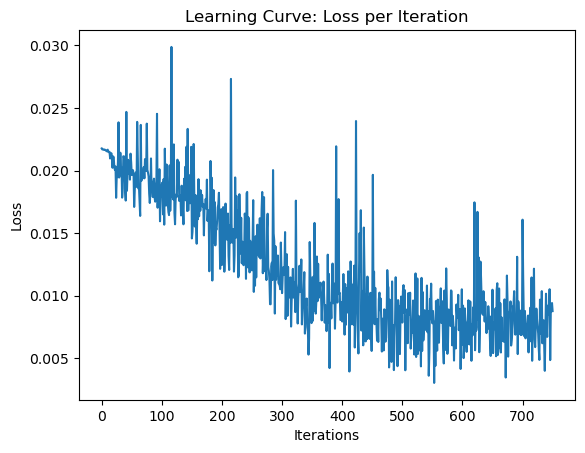

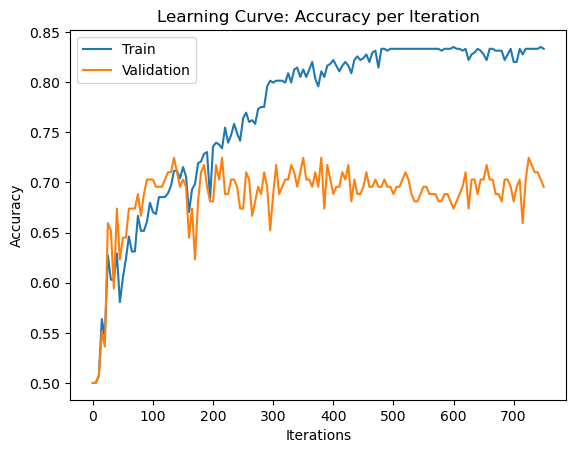

CNN channel learning curves:


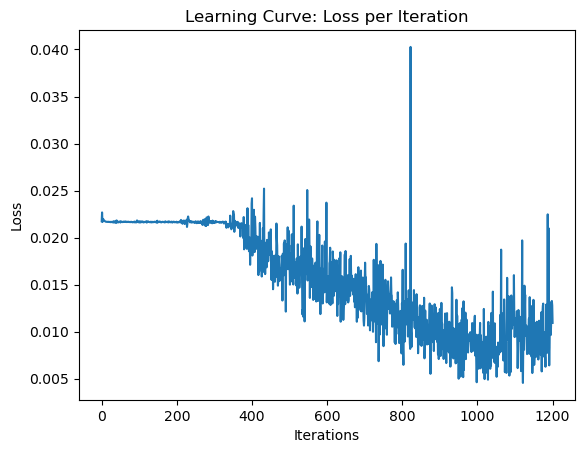

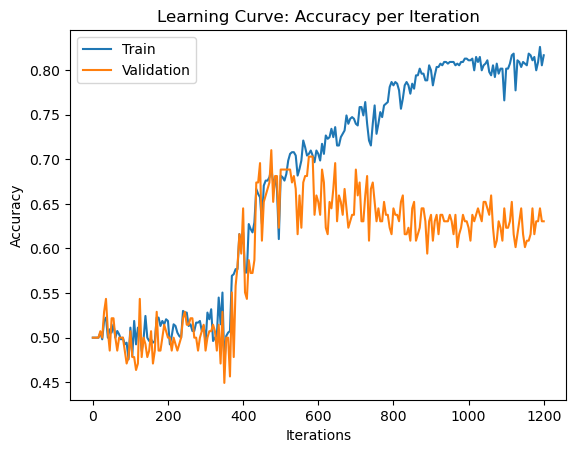

In [60]:
print("CNN learning curves:")
plot_learning_curve(*data_bestCNN)

print("CNN channel learning curves:")
plot_learning_curve(*data_bestCNNchannel)

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [45]:
# testing in which epoch we get the best valid acc:


In [63]:
pos_acc_NNch_m,neg_acc_NNch_m = get_accuracy(bestCNNchannel, valid_data, batch_size=64)
pos_acc_NNch_w,neg_acc_NNch_w = get_accuracy(bestCNNchannel, test_w, batch_size=64)

pos_acc_NN_m,neg_acc_NN_m = get_accuracy(bestCNN, test_m, batch_size=50)
pos_acc_NN_w,neg_acc_NN_w = get_accuracy(bestCNN, test_w, batch_size=50)

print("positive acc for CNNchannel for males: ",pos_acc_NNch_m *100,"%")
print("negative acc for CNNchannel for males: ",neg_acc_NNch_m*100,"%")
print("positive acc for CNNchannel for females: ",pos_acc_NNch_w*100,"%")
print("negative acc for CNNchannel for females: ",neg_acc_NNch_w*100,"%")

print("positive acc for CNN for males: ",pos_acc_NN_m,"%")
print("negative acc for CNN for males: ",neg_acc_NN_m,"%")
print("positive acc for CNN for females: ",pos_acc_NN_w,"%")
print("negative acc for CNN for females: ",neg_acc_NN_w,"%")

positive acc for CNNchannel for males:  44.927536231884055 %
negative acc for CNNchannel for males:  81.15942028985508 %
positive acc for CNNchannel for females:  46.666666666666664 %
negative acc for CNNchannel for females:  70.0 %
positive acc for CNN for males:  0.8333333333333334 %
negative acc for CNN for males:  0.4666666666666667 %
positive acc for CNN for females:  0.8333333333333334 %
negative acc for CNN for females:  0.4666666666666667 %


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.